# Deep convolutional generative adversarial network (DCGAN)

In [1]:
import time
import os

import IPython
import matplotlib.pyplot
import numpy
import sklearn.model_selection
import tensorflow
import tensorflow_probability
import tqdm.notebook

In [18]:
BATCH_SIZE = 256
DIMENSIONS = 100
EPOCHS = 2048
EXAMPLES = 16
INPUT_SHAPE = (28, 28, 1)
SEED = tensorflow.random.normal([EXAMPLES, DIMENSIONS])

In [3]:
def preprocess(image):
    image = tensorflow.image.resize(image, (28, 28))
    
    return tensorflow.image.rgb_to_grayscale(image)

def render_images(images):
    matplotlib.pyplot.figure(figsize=(12, 12))

    for index, image in enumerate(images[:25]):
        axis = matplotlib.pyplot.subplot(5, 5, index + 1)

        matplotlib.pyplot.imshow(image[:, :, 0])

        matplotlib.pyplot.axis("off")

In [4]:
%time x_0 = numpy.load("../../data/objects/0.npy")

training_0, test_0 = sklearn.model_selection.train_test_split(x_0)

CPU times: user 2.57 ms, sys: 205 ms, total: 208 ms
Wall time: 207 ms


<Figure size 864x864 with 0 Axes>

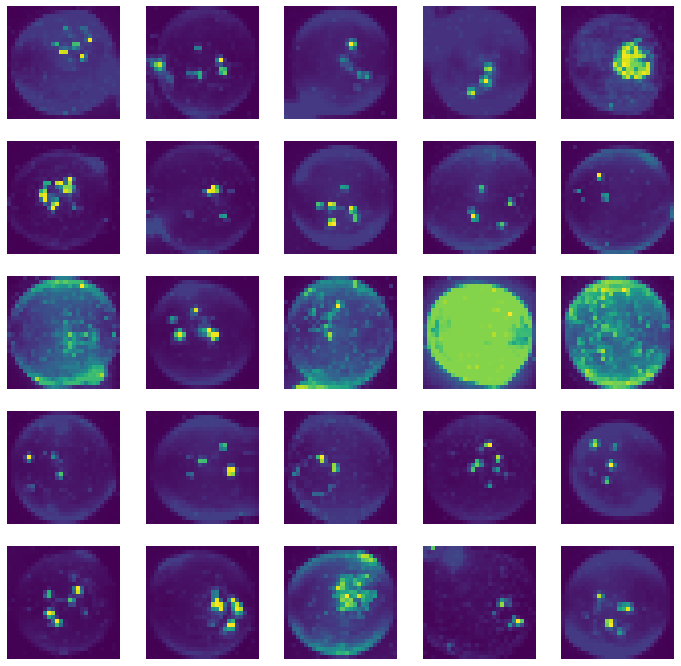

In [5]:
# Training, 0 (Membrane)

training_0 = tensorflow.data.Dataset.from_tensor_slices(training_0)

training_0 = training_0.map(preprocess, tensorflow.data.experimental.AUTOTUNE)

training_0 = training_0.cache().shuffle(1024).batch(256).prefetch(tensorflow.data.experimental.AUTOTUNE)

matplotlib.pyplot.figure(figsize=(12, 12))

render_images([image.numpy() for image in training_0.take(1)][0][:25])

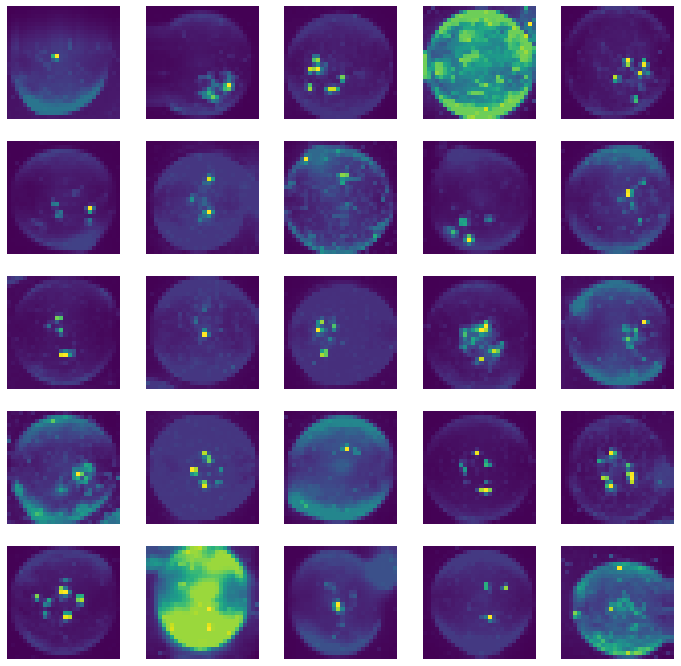

In [6]:
# Test, 0 (Membrane)

test_0 = tensorflow.data.Dataset.from_tensor_slices(test_0)

test_0 = test_0.map(preprocess, tensorflow.data.experimental.AUTOTUNE)

test_0 = test_0.cache().shuffle(1024).batch(256).prefetch(tensorflow.data.experimental.AUTOTUNE)

render_images([image.numpy() for image in test_0.take(1)][0][:25])

In [11]:
%time x_1 = numpy.load("../../data/objects/1.npy")

%time training_1, test_1 = sklearn.model_selection.train_test_split(x_1)

CPU times: user 3.85 ms, sys: 5.26 ms, total: 9.11 ms
Wall time: 7.99 ms
CPU times: user 5.98 ms, sys: 0 ns, total: 5.98 ms
Wall time: 5.67 ms


<Figure size 864x864 with 0 Axes>

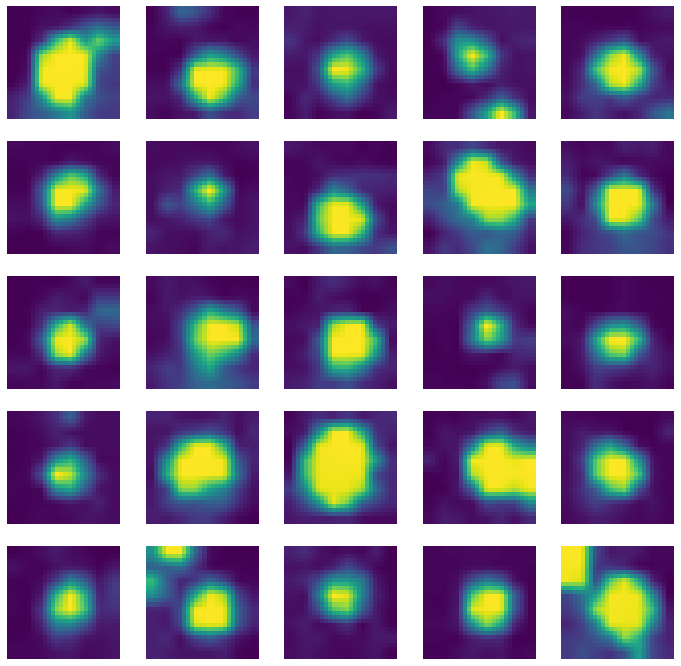

In [25]:
# Training, 1 (Foci)

training_1 = tensorflow.data.Dataset.from_tensor_slices(training_1)

training_1 = training_1.map(preprocess, tensorflow.data.experimental.AUTOTUNE)

training_1 = training_1.cache().shuffle(1024).batch(256).prefetch(tensorflow.data.experimental.AUTOTUNE)

matplotlib.pyplot.figure(figsize=(12, 12))

render_images([image.numpy() for image in training_1.take(1)][0][:25])

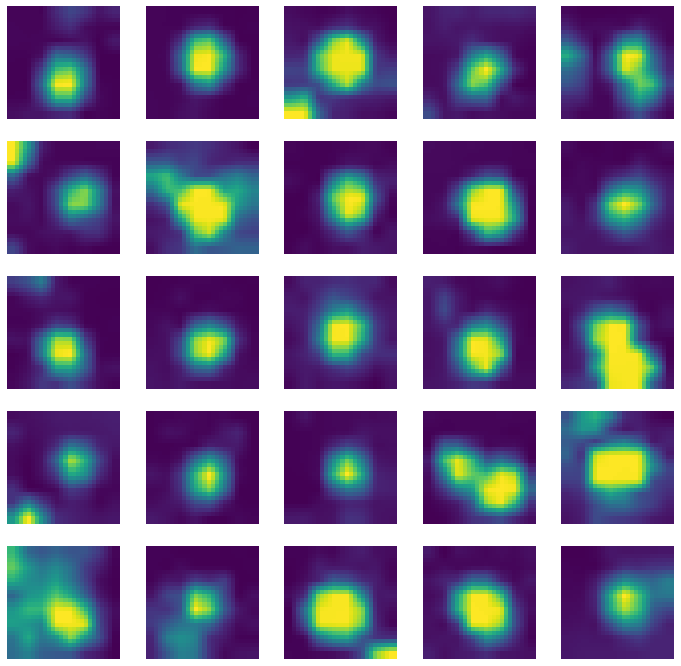

In [10]:
# Test, 1 (Foci)

test_1 = tensorflow.data.Dataset.from_tensor_slices(test_1)

test_1 = test_1.map(preprocess, tensorflow.data.experimental.AUTOTUNE)

test_1 = test_1.cache().shuffle(1024).batch(256).prefetch(tensorflow.data.experimental.AUTOTUNE)

render_images([image.numpy() for image in test_1.take(1)][0][:25])

In [12]:
generator = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(DIMENSIONS,)),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Reshape((7, 7, 256)),
    tensorflow.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'),
])

discriminator = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=INPUT_SHAPE),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Dropout(0.3),
    tensorflow.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tensorflow.keras.layers.LeakyReLU(),
    tensorflow.keras.layers.Dropout(0.3),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(1),
])

In [13]:
cross_entropy = tensorflow.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(y_pred):
    return cross_entropy(tensorflow.ones_like(y_pred), y_pred)

def discriminator_loss(y_true, y_pred):
    return cross_entropy(tensorflow.ones_like(y_true), y_true) + cross_entropy(tensorflow.zeros_like(y_pred), y_pred)

generator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_directory = "./checkpoints"

checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

checkpoint = tensorflow.train.Checkpoint(
    discriminator_optimizer=discriminator_optimizer,
    discriminator=discriminator,
    generator_optimizer=generator_optimizer,
    generator=generator,
)

discriminated: -9.48456727201119e-05


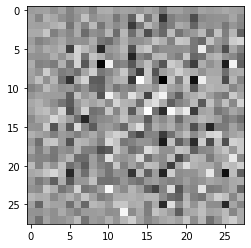

In [15]:
generated = generator(tensorflow.random.normal([1, 100]), training=False)

discriminated = discriminator(generated)

matplotlib.pyplot.imshow(generated[0, :, :, 0], cmap='gray')

print(f"discriminated: {discriminated[0][0]}")

In [29]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = matplotlib.pyplot.figure(figsize=(12, 12))

    for i in range(predictions.shape[0]):
        matplotlib.pyplot.subplot(4, 4, i + 1)
        matplotlib.pyplot.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        matplotlib.pyplot.axis('off')

    matplotlib.pyplot.savefig('./gif/image_at_epoch_{:04d}.png'.format(epoch))
    matplotlib.pyplot.show()

@tensorflow.function
def step(images):
    noise = tensorflow.random.normal([BATCH_SIZE, DIMENSIONS])

    with tensorflow.GradientTape() as generator_tape, tensorflow.GradientTape() as discriminator_tape:
        generated = generator(noise, training=True)

        y_true = discriminator(images, training=True)
        y_pred = discriminator(generated, training=True)

        loss_0 = generator_loss(y_pred)
        loss_1 = discriminator_loss(y_true, y_pred)

    generator_gradients = generator_tape.gradient(loss_0, generator.trainable_variables)
    
    discriminator_gradients = discriminator_tape.gradient(loss_1, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

def fit(dataset, epochs=EPOCHS):
    for epoch in range(epochs):
        for image_batch in dataset:
            step(image_batch)

        IPython.display.clear_output(wait=True)

        generate_and_save_images(generator, epoch + 1, SEED)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        IPython.display.clear_output(wait=True)
            
        generate_and_save_images(generator, epochs, SEED)

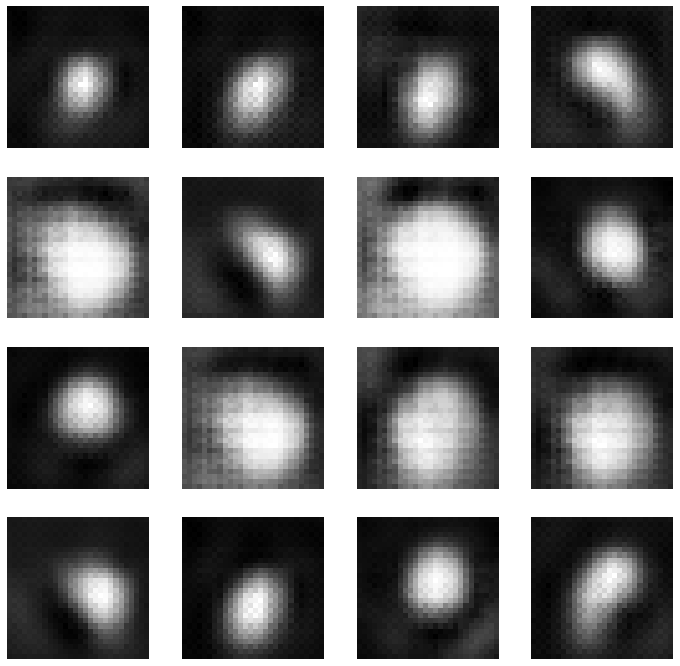

In [ ]:
fit(training_1, 1024)